### Carga del dataset


In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os


# Rutas desde el cuaderno
train_csv = 'Dataset-SupermarketImages/annotations.csv'
val_csv = 'Dataset-SupermarketImages/annotations_val.csv'
base_img_path = 'Dataset-SupermarketImages/'

# Carga de DataFrames
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)

# Verifica
df_train.head()


,image,Banana,Orange,Red-Bell-Pepper,aluminium_form,bread,doritos_cocaCola,red_bull,shampoo_H&S,tea,yogurt_toni_mix
0,Productos/Train\Banana\Banana_001.jpg,1,0,0,0,0,0,0,0,0,0
1,Productos/Train\Banana\Banana_002.jpg,1,0,0,0,0,0,0,0,0,0
2,Productos/Train\Banana\Banana_003.jpg,1,0,0,0,0,0,0,0,0,0
3,Productos/Train\Banana\Banana_004.jpg,1,0,0,0,0,0,0,0,0,0
4,Productos/Train\Banana\Banana_005.jpg,1,0,0,0,0,0,0,0,0,0


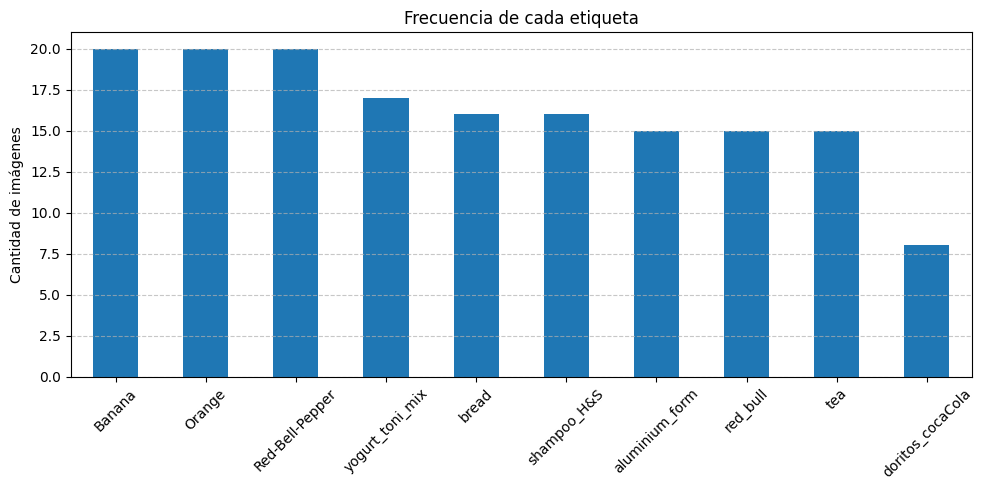

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('Dataset-SupermarketImages/annotations.csv')

# Quitar la columna de la imagen
etiquetas = df.columns[1:]  # saltarse la columna 'image'

# Sumar por columna para contar cuántas veces aparece cada etiqueta
conteo = df[etiquetas].sum().sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10, 5))
conteo.plot(kind='bar')
plt.title('Frecuencia de cada etiqueta')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def load_data(df, base_path):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = os.path.join(base_path, row['image'])
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row[1:].values.astype('float32'))

    return np.array(images), np.array(labels)

x_train, y_train = load_data(df_train, base_img_path)
x_val, y_val = load_data(df_val, base_img_path)

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)


Train: (83, 224, 224, 3) (83, 6)
Val: (29, 224, 224, 3) (29, 6)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
val_generator = val_datagen.flow(x_val, y_val, batch_size=16)


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Cargar modelo base sin la capa final
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelar pesos

# Agregamos nuestras capas arriba
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation='sigmoid')(x)  # multietiqueta

model = Model(inputs, outputs)


In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # para multietiqueta
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
6/6 [==============================] - 4s 220ms/step - loss: 0.5521 - accuracy: 0.1446 - val_loss: 0.4148 - val_accuracy: 0.3448
Epoch 2/10
6/6 [==============================] - 1s 111ms/step - loss: 0.4078 - accuracy: 0.4096 - val_loss: 0.3577 - val_accuracy: 0.6207
Epoch 3/10
6/6 [==============================] - 1s 128ms/step - loss: 0.3238 - accuracy: 0.6506 - val_loss: 0.2779 - val_accuracy: 0.6897
Epoch 4/10
6/6 [==============================] - 1s 107ms/step - loss: 0.2303 - accuracy: 0.8313 - val_loss: 0.2097 - val_accuracy: 0.9310
Epoch 5/10
6/6 [==============================] - 1s 94ms/step - loss: 0.2009 - accuracy: 0.9277 - val_loss: 0.1629 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 92ms/step - loss: 0.1538 - accuracy: 0.9518 - val_loss: 0.1332 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 119ms/step - loss: 0.1319 - accuracy: 0.9639 - val_loss: 0.1103 - val_accuracy: 1.0000
Epoch 8/10
6/6 [======

In [ ]:
model.save('supermarket_model.h5')
model.save('supermarket_model.keras') 

1/1 [==============================] - 3s 3s/step


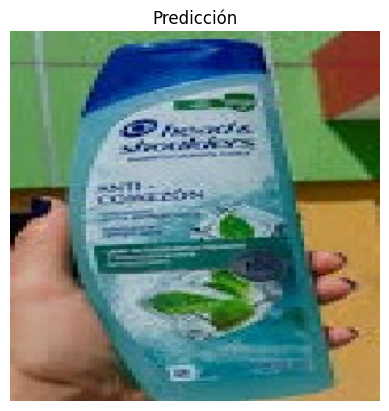

Etiquetas detectadas:
✅ shampoo_H&S


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import pandas as pd

# --- Cargar el modelo entrenado (si no está ya en memoria)
model = tf.keras.models.load_model("supermarket_model.h5")  # si lo guardaste

# --- Ruta de la imagen real (ajústala a tu caso)
img_path = 'prueba4.jpeg'

# --- Cargar imagen y preprocesar igual que las del dataset
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# --- Hacer predicción
preds = model.predict(img_array)[0]  # ya viene con forma (1, N)
preds_redondeadas = (preds > 0.5).astype(int)

# --- Mostrar la imagen
plt.imshow(img)
plt.axis('off')
plt.title("Predicción")
plt.show()

# --- Mostrar resultados
etiquetas = pd.read_csv('Dataset-SupermarketImages/annotations.csv').columns[1:]  # quitamos la columna 'file'
resultado = dict(zip(etiquetas, preds_redondeadas))

print("Etiquetas detectadas:")
for k, v in resultado.items():
    if v == 1:
        print(f"✅ {k}")
